In [1]:
# All Imports

!pip install bm3d

import bm3d

import numpy as np
from scipy.sparse.linalg import lsqr

import numpy as np
from sklearn.linear_model import Ridge
import cvxpy as cp
from skimage.restoration import denoise_tv_chambolle, denoise_nl_means
import pdb
from scipy.signal import gaussian, convolve2d
from scipy.ndimage import correlate, convolve, zoom, rotate, gaussian_filter
from numpy.fft import fft2, ifft2
from numpy import ceil, floor
import math

import scipy
import matplotlib.pyplot as plt
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.9 MB/s eta 0:00:00


In [2]:
def gaus_kernel(size, sigma):
    """Generate a 2D Gaussian kernel."""

    kernel_1d = gaussian(size, sigma)

    kernel_1d /= kernel_1d.sum()
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    return kernel_2d

def defGGt(h, K):
    def G(x): # down sample
        return fdown(x, K,h)

    def Gt(x): # up sample
        return upf(x, K,h)

    return G, Gt

def fdown(x, K,h):

    blurred_image = convolve(x, h, mode='wrap')
    # Downsample
    downsampled_image = blurred_image[::K, ::K]
    return downsampled_image

def upf(x, K,h):
    upsampled_image = zoom(x, K, order=1)
    smoothed_image = convolve(upsampled_image, h, mode='wrap')
    return smoothed_image


def constructGGt(h, K, rows, cols):

    # Convolve h with its rotated version
    h_rotated = np.rot90(h, 2)
    hth = convolve2d(h, h_rotated, mode='full')

    # Center coordinates
    yc = int(ceil(hth.shape[0] / 2))
    xc = int(ceil(hth.shape[1] / 2))

    # Width of the new filter
    L = int(floor(hth.shape[0] / K))

    # Initialize the new filter
    g = np.zeros((L, L))

    # Fill the new filter
    for i in range(-L//2, L//2):
        for j in range(-L//2, L//2):
            g[i + L//2, j + L//2] = hth[yc + K*i - 1, xc + K*j - 1]

    # Compute the absolute value of the 2D FFT
    GGt = abs(fft2(g, s=(rows//K, cols//K)))
    return GGt

def get_denoise_function(method):

    def bm3d_denoiser(vtilde, sigma):
        return bm3d.bm3d(vtilde, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES)

    def tv_denoiser(vtilde, sigma):
        return denoise_tv_chambolle(vtilde, weight=sigma)

    def nlm_denoiser(vtilde, sigma):
        patch_kw = {'patch_size': 5, 'patch_distance': 6, 'multichannel': False}
        return denoise_nl_means(vtilde, h=sigma, fast_mode=True, **patch_kw)

    if method == 'BM3D':
        return bm3d_denoiser
    elif method == 'TV':
        return tv_denoiser
    elif method == 'NLM':
        return nlm_denoiser
    else:
        raise ValueError('Unknown denoiser method: {}'.format(method))

def imresize(image, scale):
    # Calculate the new dimensions
    width = int(image.shape[1] * scale)
    height = int(image.shape[0] * scale)

    # Resize the image
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

    return resized_image
def PlugPlayADMM_general(y, A, lambda_, method, opts=None):


    # Set default options
    opts.setdefault('rho', 1)
    opts.setdefault('max_itr', 20)
    opts.setdefault('tol', 1e-4)
    opts.setdefault('gamma', 1)
    opts.setdefault('print', False)
    opts.setdefault('delta_k_parm', 0.5)


    # Initialize variables
    rho = opts['rho']
    max_itr = opts['max_itr']
    tol = opts['tol']
    gamma = opts['gamma']
    print_flag = opts['print']
    delta_k_parm = opts['delta_k_parm']



    itr = 1
    K = 2
    loss = []
    dim = y.shape
    # Denoiser mapping
    denoise = get_denoise_function(method)

    # Since Y is downsampled by 2, we want to recover it back to origianl shape
    rows_in, cols_in = y.shape
    rows, cols = rows_in * K, cols_in * K
    N = rows * cols

    h = gaus_kernel(9, 1)
    G, Gt = defGGt(h, K)
    GGt = constructGGt(h, K, rows, cols)
    Gty = Gt(y)
    v = imresize(y, K) # upsample by 2 to get original shape
    x = v
    u = np.zeros(v.shape)
    residual = np.inf



    while residual > tol and itr <= max_itr:
      # initializing old variables
      x_old = x.copy()
      v_old = v.copy()
      u_old = u.copy()
      # Inversion step
      xtilde = v - u
      rhs = Gty + rho * xtilde
      x = (rhs - Gt(np.real(ifft2(fft2(G(rhs)) / (GGt + rho))))) / rho


      # denoising step
      sig =  np.sqrt(lambda_/ rho)
      v_tild = x+u
      v_tild = np.clip(v_tild, 0,1)
      v = denoise(v_tild,sig)

      # update multiplier
      u = u + (x - v)

      # computing residual
      resid_x = (1 / np.sqrt(N)) * np.linalg.norm(x - x_old)
      resid_v = (1 / np.sqrt(N)) * np.linalg.norm(v - v_old)
      resid_u = (1 / np.sqrt(N)) * np.linalg.norm(u - u_old)

      delt_k = resid_x + resid_v + resid_u
      # adaptive update rule
      # if delt_k > delt_k * delta_k_parm:
      #   rho = rho * gamma
      rho = rho * gamma
      # update itteration
      itr +=1
      # append loss

    return x

def add_noise(image, mean=0, sigma=1):
    noise_level = 10/255;
    gauss = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + gauss * noise_level
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure values are within [0, 1]
    return noisy_image

def crop_to_smaller(arr1, arr2):
    # Determine the shape of both input arrays
    rows1, cols1 = arr1.shape
    rows2, cols2 = arr2.shape

    # Identify the smaller dimensions
    target_rows = min(rows1, rows2)
    target_cols = min(cols1, cols2)

    # Crop the first array if necessary
    if arr1.shape != (target_rows, target_cols):
        row_start1 = (rows1 - target_rows) // 2
        col_start1 = (cols1 - target_cols) // 2
        arr1_cropped = arr1[row_start1:row_start1+target_rows, col_start1:col_start1+target_cols]
    else:
        arr1_cropped = arr1

    # Crop the second array if necessary
    if arr2.shape != (target_rows, target_cols):
        row_start2 = (rows2 - target_rows) // 2
        col_start2 = (cols2 - target_cols) // 2
        arr2_cropped = arr2[row_start2:row_start2+target_rows, col_start2:col_start2+target_cols]
    else:
        arr2_cropped = arr2

    return arr1_cropped, arr2_cropped

def psnr(img1, img2):
    if img1.shape != img2.shape:
      img1, img2 = crop_to_smaller(img1, img2)
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


def display_three_images(img1, img2, img3, title1, title2, title3):
    # Create a figure to hold the images
    fig, axs = plt.subplots(3, 1, figsize=(45, 15))

    # Display first image
    axs[0].imshow(img1)
    axs[0].set_title(title1)

    # Display second image
    axs[1].imshow(img2)
    axs[1].set_title(title2)

    # Display third image
    axs[2].imshow(img3)
    axs[2].set_title(title3)

    plt.show()


# Img_path is the path to the image that you would like to perform plug_play_ADMM_super_resolution on

def plug_play_ADMM_super_resolution_run(img_path: str):
    np.random.seed(0)  # Set seed for reproducibility

    # Read in image, normalize, add noise, and add bluring
    x = plt.imread(img_path)
    x = cv2.normalize(x.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    h = gaus_kernel(9, 1) # Set a gaussian kernal for blurring
    x_blured = convolve(x, h, mode='wrap') # Blur the image
    y = fdown(x, 2,h) # Downsample image
    y = add_noise(y)  # Add noise to image

    # Set PNP ADMM parameters
    A = x_blured
    method = 'TV'
    lambda_ = 0.01
    opts = {'rho': 1, 'gamma': 1, 'max_itr': 20, 'print': True}
    # Run PNP ADMM
    out = PlugPlayADMM_general(y, A, lambda_, method,opts)

    return(A, x, y, out)



In [6]:
def gaus_kernel(size, sigma):
    """Generate a 2D Gaussian kernel."""
    # Generate a 1D Gaussian kernel using specified size and sigma
    kernel_1d = gaussian(size, sigma)
    # Normalize the kernel so that the sum of its elements equals 1
    kernel_1d /= kernel_1d.sum()
    # Create a 2D kernel by taking the outer product of the 1D kernel with itself
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    return kernel_2d

def defGGt(h, K):
    """Define functions for downsampling and upsampling using given kernel and factor."""
    def G(x): # Downsample function
        # Apply downsampling operation
        return fdown(x, K, h)

    def Gt(x): # Upsample function
        # Apply upsampling operation
        return upf(x, K, h)

    return G, Gt

def fdown(x, K, h):
    """Downsample an image by a factor of K after convolving with kernel h."""
    # Convolve the image with the kernel and use wrap mode for edge handling
    blurred_image = convolve(x, h, mode='wrap')
    # Downsample the image by taking every K-th pixel in both dimensions
    downsampled_image = blurred_image[::K, ::K]
    return downsampled_image

def upf(x, K, h):
    """Upsample an image by a factor of K and then smooth it using kernel h."""
    # Upsample the image by zooming it with a given factor K
    upsampled_image = zoom(x, K, order=1)
    # Smooth the upsampled image by convolving it with the kernel
    smoothed_image = convolve(upsampled_image, h, mode='wrap')
    return smoothed_image

def constructGGt(h, K, rows, cols):
    """Compute the 2D FFT of the convolution of h with its rotated version, downsampled by K."""
    # Rotate the kernel h by 180 degrees to get its rotated version
    h_rotated = np.rot90(h, 2)
    # Convolve h with its rotated version
    hth = convolve2d(h, h_rotated, mode='full')

    # Find the center of the resulting convolution
    yc = int(ceil(hth.shape[0] / 2))
    xc = int(ceil(hth.shape[1] / 2))

    # Determine the width of the new filter after downsampling
    L = int(floor(hth.shape[0] / K))

    # Initialize the new filter
    g = np.zeros((L, L))

    # Fill the new filter with appropriate elements from the convolved matrix
    for i in range(-L//2, L//2):
        for j in range(-L//2, L//2):
            g[i + L//2, j + L//2] = hth[yc + K*i - 1, xc + K*j - 1]

    # Compute the absolute value of the 2D FFT of the new filter
    GGt = abs(fft2(g, s=(rows//K, cols//K)))
    return GGt

def get_denoise_function(method):
    """Return a denoising function based on the specified method."""
    # Define BM3D denoising function
    def bm3d_denoiser(vtilde, sigma):
        # Apply BM3D denoising algorithm
        return bm3d.bm3d(vtilde, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES)

    # Define TV denoising function
    def tv_denoiser(vtilde, sigma):
        # Apply total variation denoising
        return denoise_tv_chambolle(vtilde, weight=sigma)

    # Define NLM denoising function
    def nlm_denoiser(vtilde, sigma):
        # Apply non-local means denoising
        patch_kw = {'patch_size': 5, 'patch_distance': 6, 'multichannel': False}
        return denoise_nl_means(vtilde, h=sigma, fast_mode=True, **patch_kw)

    # Return the corresponding denoising function
    if method == 'BM3D':
        return bm3d_denoiser
    elif method == 'TV':
        return tv_denoiser
    elif method == 'NLM':
        return nlm_denoiser
    else:
        raise ValueError('Unknown denoiser method: {}'.format(method))

def imresize(image, scale):
    """Resize an image by a given scale factor."""
    # Calculate the new dimensions based on the scale factor
    width = int(image.shape[1] * scale)
    height = int(image.shape[0] * scale)
    # Resize the image using linear interpolation
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
    return resized_image

def PlugPlayADMM_general(y, A, lambda_, method, opts=None):
    """Implement the plug-and-play ADMM algorithm for image recovery."""
    if opts is None:
        opts = {}

    # Set default options if not provided
    opts.setdefault('rho', 1)
    opts.setdefault('max_itr', 20)
    opts.setdefault('tol', 1e-4)
    opts.setdefault('gamma', 1)
    opts.setdefault('print', False)
    opts.setdefault('delta_k_parm', 0.5)

    # Initialize variables from options
    rho = opts['rho']
    max_itr = opts['max_itr']
    tol = opts['tol']
    gamma = opts['gamma']
    print_flag = opts['print']
    delta_k_parm = opts['delta_k_parm']

    itr = 1
    K = 2  # Downsampling factor
    loss = []
    dim = y.shape
    # Get denoising function based on method
    denoise = get_denoise_function(method)

    # Calculate the dimensions for the upsampled image
    rows_in, cols_in = y.shape
    rows, cols = rows_in * K, cols_in * K
    N = rows * cols  # Total number of pixels

    # Generate Gaussian kernel for blurring
    h = gaus_kernel(9, 1)
    # Define downsampling and upsampling functions
    G, Gt = defGGt(h, K)
    # Compute the convolution matrix for the system
    GGt = constructGGt(h, K, rows, cols)
    # Apply Gt to the observed image
    Gty = Gt(y)
    # Upsample the observed image to get an initial estimate
    v = imresize(y, K)
    x = v  # Initial solution
    u = np.zeros(v.shape)  # Dual variable
    residual = np.inf

    # Iterate until convergence or maximum iterations reached
    while residual > tol and itr <= max_itr:
        # Save previous iteration values
        x_old = x.copy()
        v_old = v.copy()
        u_old = u.copy()

        # Inversion step
        xtilde = v - u
        rhs = Gty + rho * xtilde
        x = (rhs - Gt(np.real(ifft2(fft2(G(rhs)) / (GGt + rho))))) / rho

        # Denoising step
        sig = np.sqrt(lambda_ / rho)
        v_tild = x + u
        v_tild = np.clip(v_tild, 0, 1)
        v = denoise(v_tild, sig)

        # Update multiplier
        u = u + (x - v)

        # Compute residuals for convergence check
        resid_x = (1 / np.sqrt(N)) * np.linalg.norm(x - x_old)
        resid_v = (1 / np.sqrt(N)) * np.linalg.norm(v - v_old)
        resid_u = (1 / np.sqrt(N)) * np.linalg.norm(u - u_old)

        delt_k = resid_x + resid_v + resid_u
        rho = rho * gamma  # Update rho according to gamma

        itr += 1  # Increment iteration count

    return x

def add_noise(image, mean=0, sigma=1):
    """Add Gaussian noise to an image."""
    noise_level = 10 / 255
    gauss = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + gauss * noise_level
    noisy_image = np.clip(noisy_image, 0, 1)  # Ensure values are within [0, 1]
    return noisy_image

def crop_to_smaller(arr1, arr2):
    """Crop two arrays to the size of the smaller array."""
    # Determine shapes of both arrays
    rows1, cols1 = arr1.shape
    rows2, cols2 = arr2.shape

    # Find smaller dimensions
    target_rows = min(rows1, rows2)
    target_cols = min(cols1, cols2)

    # Crop the first array to target size
    arr1_cropped = arr1[(rows1 - target_rows) // 2:(rows1 + target_rows) // 2,
                        (cols1 - target_cols) // 2:(cols1 + target_cols) // 2]

    # Crop the second array to target size
    arr2_cropped = arr2[(rows2 - target_rows) // 2:(rows2 + target_rows) // 2,
                        (cols2 - target_cols) // 2:(cols2 + target_cols) // 2]

    return arr1_cropped, arr2_cropped

def psnr(img1, img2):
    """Calculate the PSNR between two images."""
    if img1.shape != img2.shape:
        img1, img2 = crop_to_smaller(img1, img2)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def display_three_images(img1, img2, img3, title1, title2, title3):
    """Display three images side by side with titles."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(img1, cmap='gray')
    axs[0].set_title(title1)

    axs[1].imshow(img2, cmap='gray')
    axs[1].set_title(title2)

    axs[2].imshow(img3, cmap='gray')
    axs[2].set_title(title3)

    plt.show()

# Note: For the actual implementation of denoising functions like bm3d.bm3d, denoise_tv_chambolle, and denoise_nl_means,
# additional imports or library functions would be required, which are not included here.


In [4]:
A, x, y, out = plug_play_ADMM_super_resolution_run('/content/peppers256.png')

<ipython-input-3-e3221f8fb92e>:4: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel_1d = gaussian(size, sigma)


PSNR: 56.182582884664036


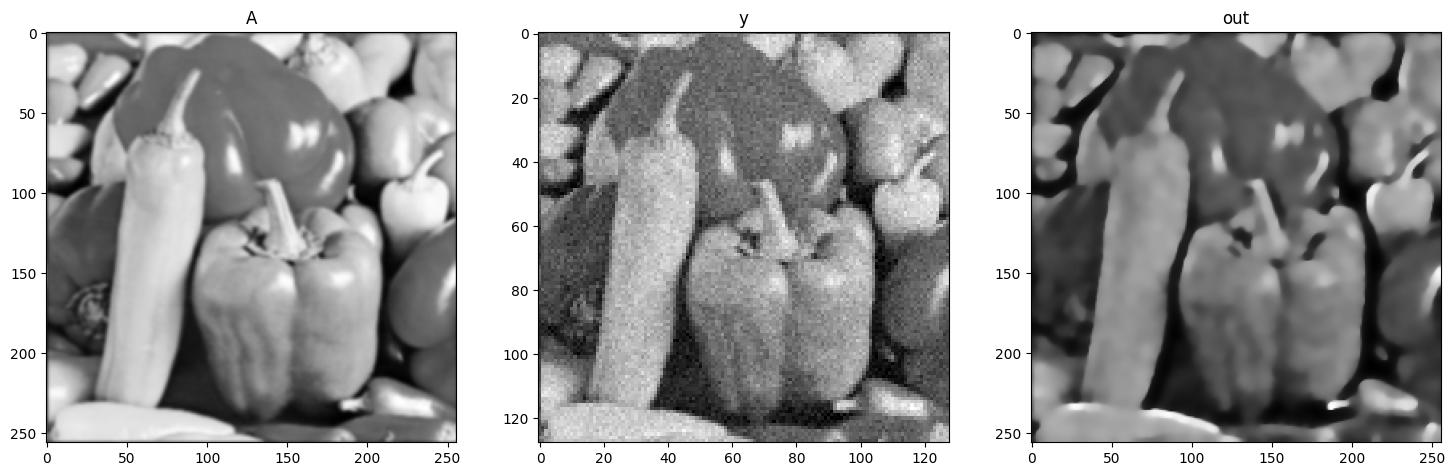

In [7]:
PSNR_output = psnr(out,x)
print(f"PSNR: {PSNR_output}")
display_three_images(A, y, out, 'A', 'y', 'out')